In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorAR
from model import MPNNLSTM, MPNNLSTMI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (modified) MovingMNIST

In [19]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)


input_features = 1
input_timesteps=3
output_timesteps=1

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(1000, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=True)

## Modelling

In [15]:
# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
nn = MPNNLSTMI(
    hidden_size=64,
    dropout=0.1,
    input_timesteps=input_timesteps,
    input_features=input_features+3,
    output_features=input_features).float()
    
model = NextFramePredictorAR(nn, thresh=0.5, experiment_name='full', decompose=True, input_features=input_features, multi_step_loss=output_timesteps)
model.get_n_params()
model.model

MPNNLSTMI(
  (recurrents): ModuleList(
    (0): GConvLSTM(
      (conv_x_i): GCNConv(4, 64)
      (conv_h_i): GCNConv(64, 64)
      (conv_x_f): GCNConv(4, 64)
      (conv_h_f): GCNConv(64, 64)
      (conv_x_c): GCNConv(4, 64)
      (conv_h_c): GCNConv(64, 64)
      (conv_x_o): GCNConv(4, 64)
      (conv_h_o): GCNConv(64, 64)
    )
    (1): GConvLSTM(
      (conv_x_i): GCNConv(64, 64)
      (conv_h_i): GCNConv(64, 64)
      (conv_x_f): GCNConv(64, 64)
      (conv_h_f): GCNConv(64, 64)
      (conv_x_c): GCNConv(64, 64)
      (conv_h_c): GCNConv(64, 64)
      (conv_x_o): GCNConv(64, 64)
      (conv_h_o): GCNConv(64, 64)
    )
  )
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)

### Threshold selection

Test different thresholds and check the image reconstruction.
We want to ensure the reconstruction keeps all detail we wish to 
preserve. 

Here, 0.1 is too high as all pixels and we get a single cell representing 
the entire image. Obviously bad. With 0.001 we don't get any data reduction
and the number of cells is equal to the number of pixels. This would work, 
and would be equivalent to setting decompose=False. 

A threshold of 0.01 keeps the digit in full detail while reducing the number
of cells significantly. 

Note that you can check different frames in your input to be more confident
that threshold works across the dataset and not just for the a single set of 
frames. 

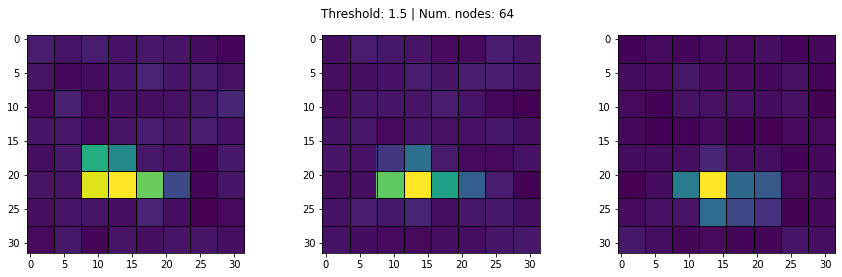

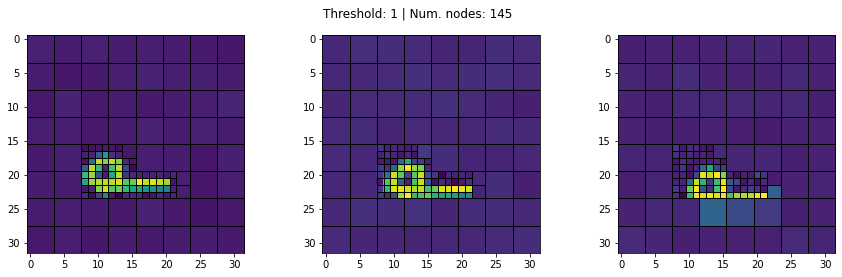

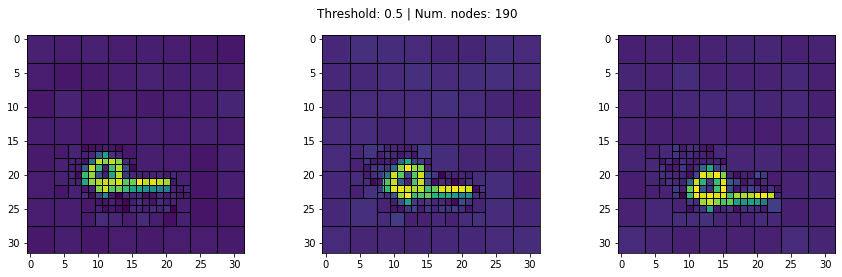

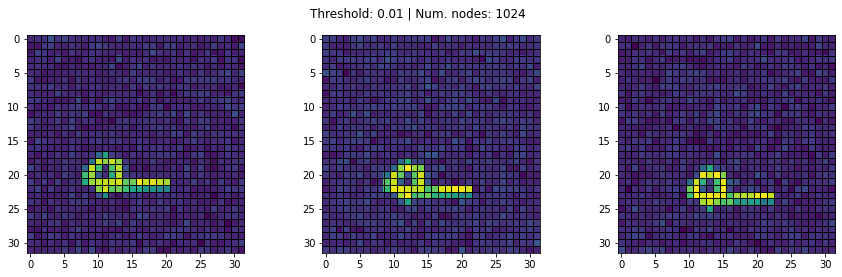

In [20]:
frame_index = 0
x_viz = loader_val.dataset.x

fig, axs = model.test_threshold(x_viz, thresh=1.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=1, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=0.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x_viz, thresh=0.01, frame_index=frame_index)
plt.show()

### Training

In [24]:
lr = 0.01

model.model.train()
model.train(loader_train, loader_test, lr=lr, n_epochs=10)  # Train for 20 epochs

model.model.eval()
model.score(x_val, y_val[:, :1])  # Check the MSE on the validation set

TypeError: train() missing 2 required positional arguments: 'x_test' and 'y_test'

### Visualize results

In [6]:
ar_steps = 4

# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(x_val, ar_steps)

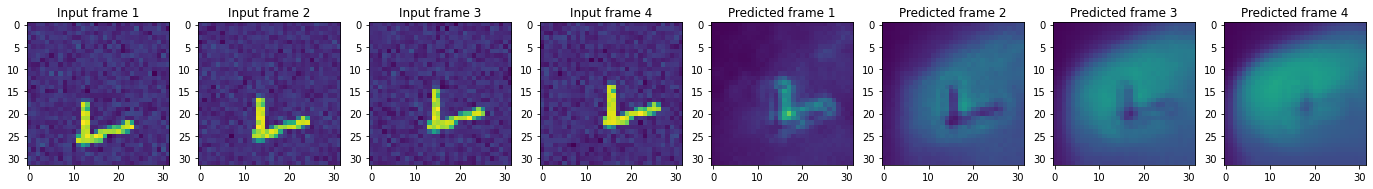

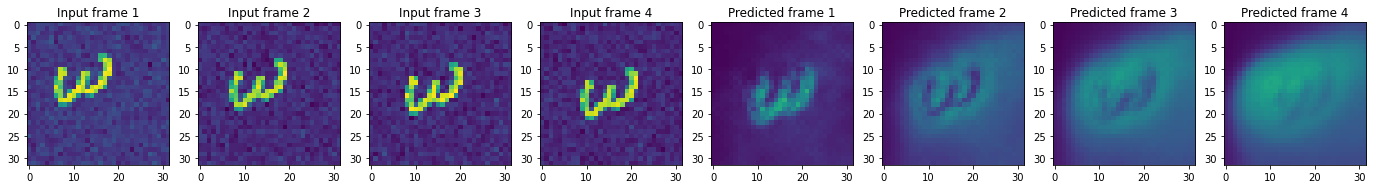

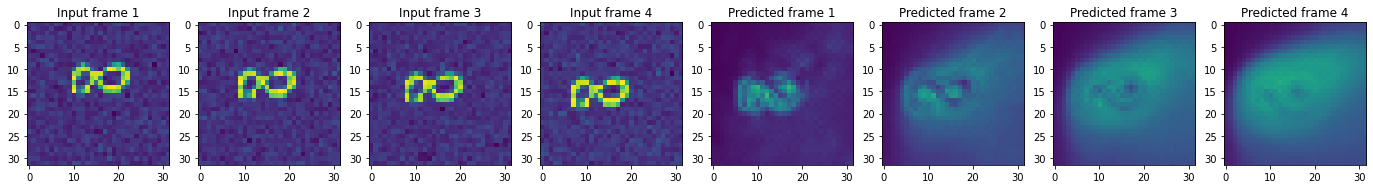

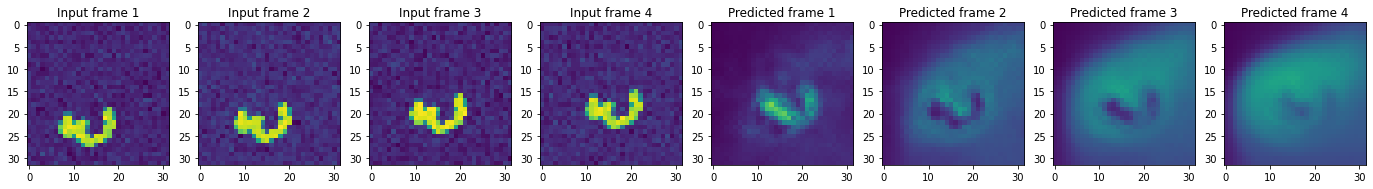

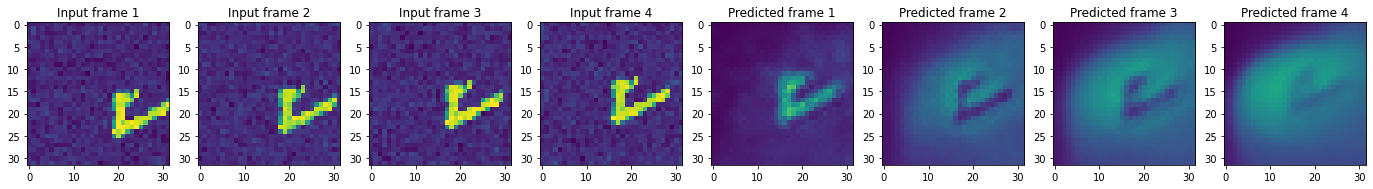

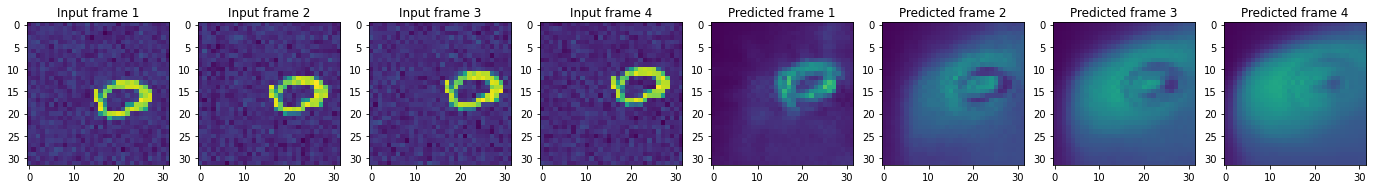

In [7]:
# Plot some example 
for i in range(6, 12):
    fig, axs = plt.subplots(1, 4+ar_steps, figsize=(12+3*ar_steps, 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(x_val[i][j, ..., 0])
        axs[j].set_title(f'Input frame {j+1}')
    
    for j in range(ar_steps):
        axs[input_timesteps + j].imshow(y_hat[i][j], vmin=0, vmax=1)  # Prediction
        axs[input_timesteps + j].set_title(f'Predicted frame {j+1}')

<AxesSubplot: >

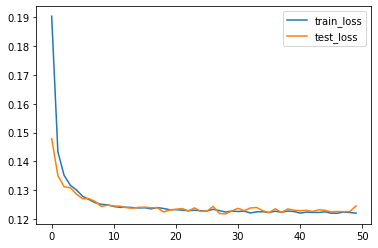

In [8]:
model.loss.plot()

In [9]:
model.loss.to_csv('results/losses_full_paper.csv')
model.save('results')

In [ ]:
# autoregressive_steps = 24
# frame_i = 2

# y_hat = model.predict(x_val, autoregressive_steps)
# for i in range(input_timesteps):
#     plt.imshow(x_val[frame_i][i, ..., 0], vmin=0, vmax=1)
#     plt.title(f'Input {i}')
#     plt.show()
    
# for i in range(autoregressive_steps):
#     plt.imshow(y_hat[frame_i][i], vmin=0, vmax=1)
#     plt.title(f'Prediction {i}')
#     plt.show()
    
# # TODO: Make it so the graph is recalculated in autoregressive mode !
# # Could we use a multi-task network which learns the remeshing through 
# # simply predicting a "density" 